<a href="https://colab.research.google.com/github/ostenloo/chess-gpt/blob/main/chessgpt-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chess 
!pip install torch 
!pip install stockfish 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 14.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch 
import torch.nn as nn 
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import chess 
import chess.pgn 
import chess.engine
from stockfish import Stockfish

import math 
import matplotlib.pyplot as plt
from dataclasses import dataclass 
import numpy as np 
import os 
import time 
import asyncio
from contextlib import nullcontext
import inspect 

print("Chess", chess.__version__)
print("Torch", torch.__version__)

Chess 1.9.4
Torch 2.0.0+cu118


In [3]:
# for colab 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

Only need to run once. Create a data folder before running. 

### 1. Generate PGN and FEN files for Black and White Colors

In [ ]:
# file_path = "/content/drive/My Drive/chessdata/Tal.pgn"

# # save the games based on if tal played white or black
# games = {
#     "white": [], 
#     "black": []
# }

# with open(file_path) as f: 
#     lines = f.readlines() 
#     tal_color = None 
#     on_pgn_line = False  
#     pgn = ""
#     for line in lines:
#         if on_pgn_line:
#             if line.startswith("[Event"): 
#                 on_pgn_line = False 
#                 games[tal_color].append(pgn)
#                 pgn = ""
#             else: 
#                 pgn += line 
#         if line.startswith("[White "): 
#             player_white = line.split('"')[1]
#             if player_white == "Tal, Mihail":
#                 tal_color = "white"
#         elif line.startswith("[Black "):
#             player_black = line.split('"')[1]
#             if player_black == "Tal, Mihail":
#                 tal_color = "black"
#         elif line.startswith("1."): 
#             on_pgn_line = True 
#             pgn += line 
#         else: 
#             # print(tal_color)
#             continue 


# f.close()  

# with open("/content/drive/My Drive/chessdata/tal_white_games.pgn", "w") as f: 
#     for game in games["white"]:
#         f.write(game)

# f.close()

# with open("/content/drive/My Drive/chessdata/tal_black_games.pgn", "w") as f:
#     for game in games["black"]:
#         f.write(game)

# f.close()

### 2. Generate UCI Vocab

In [ ]:
# from itertools import product

# files = ["a", "b", "c", "d", "e", "f", "g", "h"]
# ranks = ["1", "2", "3", "4", "5", "6", "7", "8"]
# promotion = ["Q", "R", "B", "N"]

# # gets an upper bound for the UCI vocab

# with open("/content/drive/My Drive/chessdata/UCIvocab.txt", "w") as f:
#     for file1, rank1, file2, rank2 in product(files, ranks, files, ranks):
#         if file1 == file2 and rank1 == rank2:
#             continue 
#         if rank2 == "8" and rank1 == "7" or rank2 == "1" and rank1 == "2":
#             idx1 = files.index(file1)
#             idx2 = files.index(file2)
#             if abs(idx1 - idx2) > 1:
#                 continue
#             for promotion_piece in promotion:
#                 f.write(f'{file1}{rank1}{file2}{rank2}{promotion_piece}\n') 
#         f.write(f'{file1}{rank1}{file2}{rank2}\n')

# f.close() 

### 3. Generate PGN Vocab

In [ ]:
# pieces = ["K", "Q", "R", "B", "N"] 
# print(pieces[1:])
# ranks = ["1", "2", "3", "4", "5", "6", "7", "8"]
# for rank in ranks[1:7]:
#     print(rank)

In [ ]:
# pieces = ["K", "Q", "R", "B", "N"] 
# pawns = ["a", "b", "c", "d", "e", "f", "g", "h"]
# files = ["a", "b", "c", "d", "e", "f", "g", "h"]
# ranks = ["1", "2", "3", "4", "5", "6", "7", "8"]

# moves = set()

# for piece in pieces: 
#     for file in files: 
#         for rank in ranks: 
#             moves.add(f"{piece}{file}{rank}")
#             moves.add(f"{piece}{file}{rank}+")
#             moves.add(f"{piece}{file}{rank}#")
#             moves.add(f"{piece}x{file}{rank}")
#             moves.add(f"{piece}x{file}{rank}+")
#             moves.add(f"{piece}x{file}{rank}#")
#             # 2 pieces can move to the same square 
#             if piece == "R" or piece == "N" or piece == "B" or piece == "Q": 
#                 for rank1 in ranks: 
#                     moves.add(f"{piece}{rank1}{file}{rank}")
#                     moves.add(f"{piece}{rank1}{file}{rank}+")
#                     moves.add(f"{piece}{rank1}{file}{rank}#")
#                     moves.add(f"{piece}{rank1}x{file}{rank}")
#                     moves.add(f"{piece}{rank1}x{file}{rank}+")
#                     moves.add(f"{piece}{rank1}x{file}{rank}#")
#                 for file1 in files: 
#                     moves.add(f"{piece}{file1}{file}{rank}")
#                     moves.add(f"{piece}{file1}{file}{rank}+")
#                     moves.add(f"{piece}{file1}{file}{rank}#")
#                     moves.add(f"{piece}{file1}x{file}{rank}")
#                     moves.add(f"{piece}{file1}x{file}{rank}+")
#                     moves.add(f"{piece}{file1}x{file}{rank}#")
#                 # if there are 3 pieces due to promotion, need to specify file and rank 
#                 for rank1 in ranks: 
#                     for file1 in files: 
#                         moves.add(f"{piece}{file1}{rank1}{file}{rank}")
#                         moves.add(f"{piece}{file1}{rank1}{file}{rank}+")
#                         moves.add(f"{piece}{file1}{rank1}{file}{rank}#")
#                         moves.add(f"{piece}{file1}{rank1}x{file}{rank}")
#                         moves.add(f"{piece}{file1}{rank1}x{file}{rank}+")
#                         moves.add(f"{piece}{file1}{rank1}x{file}{rank}#")

# for (idx, pawn) in enumerate(pawns): 
#     for rank in ranks[1:7]: #2,3,4,5,6,7
#         if pawn == "a": 
#             if rank == "7": 
#                 for piece in pieces[1:]: 
#                     moves.add(f"{pawn}xb{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}xb{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}xb{str(int(rank)+1)}={piece}#")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}#")
#             elif rank == "2":
#                 for piece in pieces[1:]:
#                     moves.add(f"{pawn}xb{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}xb{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}xb{str(int(rank)-1)}={piece}#")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}#")
#             else: 
#                 moves.add(f"{pawn}xb{str(int(rank)+1)}")
#                 moves.add(f"{pawn}xb{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}xb{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}xb{str(int(rank)-1)}")
#                 moves.add(f"{pawn}xb{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}xb{str(int(rank)-1)}#")
#                 moves.add(f"{pawn}{str(int(rank)+1)}")
#                 moves.add(f"{pawn}{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}{str(int(rank)-1)}")
#                 moves.add(f"{pawn}{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}{str(int(rank)-1)}#")
#         elif pawn == "h": 
#             if rank == "7":
#                 for piece in pieces[1:]:
#                     moves.add(f"{pawn}xg{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}xg{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}xg{str(int(rank)+1)}={piece}#")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}#")
#             elif rank == "2":
#                 for piece in pieces[1:]:
#                     moves.add(f"{pawn}xg{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}xg{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}xg{str(int(rank)-1)}={piece}#")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}#")
#             else: 
#                 moves.add(f"{pawn}xg{str(int(rank)+1)}")
#                 moves.add(f"{pawn}xg{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}xg{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}xg{str(int(rank)-1)}")
#                 moves.add(f"{pawn}xg{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}xg{str(int(rank)-1)}#")
#                 moves.add(f"{pawn}{str(int(rank)+1)}")
#                 moves.add(f"{pawn}{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}{str(int(rank)-1)}")
#                 moves.add(f"{pawn}{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}{str(int(rank)-1)}#")
#         else: 
#             if rank == "7":
#                 for piece in pieces[1:]: 
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)+1)}={piece}#")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}={piece}#")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}={piece}")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}={piece}+")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}={piece}#")
#             elif rank == "2":
#                 for piece in pieces[1:]: 
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}{str(int(rank)-1)}={piece}#")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}={piece}#")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}={piece}")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}={piece}+")
#                     moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}={piece}#")
#             else: 
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}")
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}")
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}x{pawns[idx-1]}{str(int(rank)-1)}#")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}x{pawns[idx+1]}{str(int(rank)-1)}#")
#                 moves.add(f"{pawn}{str(int(rank)+1)}")
#                 moves.add(f"{pawn}{str(int(rank)+1)}+")
#                 moves.add(f"{pawn}{str(int(rank)+1)}#")
#                 moves.add(f"{pawn}{str(int(rank)-1)}")
#                 moves.add(f"{pawn}{str(int(rank)-1)}+")
#                 moves.add(f"{pawn}{str(int(rank)-1)}#")

# # add castling         
# moves.add("O-O")
# moves.add("O-O+")
# moves.add("O-O#")
# moves.add("O-O-O")
# moves.add("O-O-O+")
# moves.add("O-O-O#")

# with open("/content/drive/My Drive/chessdata/PGNVocab.txt", "w") as f: 
#     f.write("<eos>\n1-0\n0-1\n1/2-1/2\n\n*\n")
#     for move in moves: 
#         f.write(move + "\n")

# f.close() 

In [ ]:
# file_names = ["tal_black_games", "tal_white_games"]

# for file in file_names:
#     pgn = open(f"/content/drive/My Drive/chessdata/{file}.pgn", 'r')
#     iter = 0 
#     while iter < 1: 
#         iter += 1 
#         game = chess.pgn.read_game(pgn)
#         if game is None: 
#             break
#         board = game.board()
#         # print(type(board)) 
#         for move in game.mainline_moves():
#             # print(type(move))
#             # print(move)
#             # print(board.san(move)) 
#             board.push(move) 
#             # print(move) #uci 
#             # print(board.fen()) #fen
#             # print(board.san(move))
#             # how to get pgn? 

#     pgn.close()

### 4. Generate PGNVocab Stripped of + and \#  

In [ ]:
# moves = []
# move_set = set()

# with open("/content/drive/My Drive/chessdata/PGNVocab.txt", "r") as f: 
#     lines = f.readlines() 
#     for line in lines:
#         line = line.strip("+#\n")
#         if line not in move_set:
#             moves.append(line)
#             move_set.add(line)

# f.close() 

# with open("/content/drive/My Drive/chessdata/PGNVocabStrip.txt", "w") as f: 
#     for move in moves: 
#         f.write(move + "\n")

## Chess Agent used to interface with Stockfish engine

In [4]:
@dataclass 
class ChessAgentConfig: 
    depth: int = 20 # engine depth 
    mate_score: int = 10000 # engine mate score

class ChessAgent: 
    def __init__(self, config):
        self.engine = chess.engine.SimpleEngine.popen_uci("stockfish")
        self.config = config 

    def fen_and_pgn_from_uci(self, uci, fen): 
        board = chess.Board(fen)
        move = chess.Move.from_uci(uci)
        pgn = board.san(move)
        board.push(move)
        fen = board.fen()
        
        return fen, pgn 

    def legal_moves(self, fen): 
        board = chess.Board(fen)
        legal_moves = list(board.legal_moves)

        return legal_moves 

    async def async_position_info(self, fen): 
        board = chess.Board(fen)
        return self.engine.analyse(board, chess.engine.Limit(depth=20))

    async def async_position_eval(self, fen): 
        info = await self.async_position_info(fen)
        return info["score"].white().score(mate_score=self.config.mate_score)

    def position_info(self, fen): 
        board = chess.Board(fen)
        return self.engine.analyse(board, chess.engine.Limit(depth=20))

    def position_eval(self, fen): 
        info = self.position_info(fen)
        return info["score"].white().score(mate_score=self.config.mate_score)

    def quit(self): 
        self.engine.quit()

asyncio.set_event_loop_policy(chess.engine.EventLoopPolicy())

In [ ]:
# chessConfig = ChessAgentConfig()

# chessAgent = ChessAgent(chessConfig) 

# fen, pgn = chessAgent.fen_and_pgn_from_uci("e2e4","rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -")

In [ ]:
# black_mate_in_1 = "rnbqkbnr/pppp1ppp/4p3/8/5PP1/8/PPPPP2P/RNBQKBNR b KQkq - 0 2"
# white_mate_in_1 = "rnbqkbnr/ppppp2p/8/5pp1/4P3/8/PPPPQPPP/RNB1KBNR w KQkq - 0 3"

# print(chess.Board(black_mate_in_1))
# eval_black = await chessAgent.position_eval(black_mate_in_1)
# print("Black Eval: ", eval_black)
# print("\n")
# print(chess.Board(white_mate_in_1))
# eval_white = await chessAgent.position_eval(white_mate_in_1)
# print("White Eval: ", eval_white)

# chessAgent.quit()

## PyTorch Custom Dataset Class to be used in Dataloader

In [8]:
class ChessDataset(Dataset): 
    def __init__(self, white, black): 
        super().__init__()

        assert os.path.exists(f"/content/drive/My Drive/chessdata/{white}.pgn"), f"/content/drive/My Drive/chessdata/{white}.pgn does not exist" 
        assert os.path.exists(f"/content/drive/My Drive/chessdata/{white}_fen.txt"), f"/content/drive/My Drive/chessdata/{white}_fen.txt does not exist" 

        self.white_uci = self.load_uci_moves(white)
        self.white_fen = self.load_fen_moves(white)
        self.white_pgn = self.load_pgn_moves(white)

        assert len(self.white_uci) == len(self.white_fen), f"white_uci and white_fen are not the same length"

        assert os.path.exists(f"/content/drive/My Drive/chessdata/{black}.pgn"), f"/content/drive/My Drive/chessdata/{black}.pgn does not exist"
        assert os.path.exists(f"/content/drive/My Drive/chessdata/{black}_fen.txt"), f"/content/drive/My Drive/chessdata/{black}_fen.txt does not exist"

        self.black_uci = self.load_uci_moves(black)
        self.black_fen = self.load_fen_moves(black)
        self.black_pgn = self.load_pgn_moves(black)

        assert len(self.black_uci) == len(self.black_fen), f"black_uci and black_fen are not the same length"

        self.pgn_vocab = self.load_pgn_vocab()

        self.pgn_vocab_stripped = self.load_pgn_vocab_stripped() 

        self.pad_game_length()

        self.to_numpy()

    def load_pgn_vocab(self): 
        vocab = open("/content/drive/My Drive/chessdata/PGNVocab.txt", 'r')
        vocab_dict = dict()
        for (idx,line) in enumerate(vocab.readlines()): 
            vocab_dict[line.strip("\n")] = idx
            
        vocab.close() 

        return vocab_dict

    def load_pgn_vocab_stripped(self): 
        vocab = open("/content/drive/My Drive/chessdata/PGNVocabStrip.txt", 'r')
        vocab_dict = dict()
        for (idx,line) in enumerate(vocab.readlines()): 
            vocab_dict[line.strip("\n")] = idx
            
        vocab.close() 

        return vocab_dict
        
    def load_fen_moves(self, file_name): 
        with open(f"/content/drive/My Drive/chessdata/{file_name}_fen.txt", 'r') as f: 
            lines = f.readlines() 
            games = []
            for line in lines: 
                games.append(line.strip("\n").split(";")[:-1])
        f.close() 

        return games

    def load_uci_moves(self, file_name): 
        pgn = open(f"/content/drive/My Drive/chessdata/{file_name}.pgn", 'r')
        games = [] 

        while True: 
            game = chess.pgn.read_game(pgn)
            if game is None: 
                break
            board = game.board() 
            moves = []
            for move in game.mainline_moves(): 
                moves.append(str(move))
            games.append(moves)
        
        return games 

    def load_pgn_moves(self, file_name): 
        pgn = open(f"/content/drive/My Drive/chessdata/{file_name}.pgn", "r")
        games = [] 

        pgn_content = pgn.read() 

        games = pgn_content.split("\n\n")[:-1]

        game_move_list = []

        for game in games: 
            moves = [move[max(0,move.find(".")+1):].strip("+#\n") for move in game.split(" ")]
            game_move_list.append(moves)

        return game_move_list

    def __len__(self): 
        return len(self.white_uci) + len(self.black_uci)

    # for pgn moves 
    def to_numpy(self): 
        stoi = { move:i for i, move in enumerate(self.pgn_vocab_stripped) }
        itos = { i:move for i, move in enumerate(self.pgn_vocab_stripped) }

        def encode(pgn): 
            return [stoi[move] for move in pgn]
        def decode(l): 
            return [itos[i] for i in l]

        # print(self.white_pgn[0:10])
        
        self.white_pgn_np = np.array([encode(pgn) for pgn in self.white_pgn])
        self.black_pgn_np = np.array([encode(pgn) for pgn in self.black_pgn])

    # required for batch loading 
    def pad_game_length(self): 
        max_len = 512 
        lists = [self.white_uci, self.black_uci, self.white_fen, self.black_fen, self.white_pgn, self.black_pgn]
        self.game_lengths = []
        for game_list in lists:
            for game in game_list:
                game_len = len(game)
                if game_list == self.white_pgn or game_list == self.black_pgn: 
                  self.game_lengths.append(game_len)
                while game_len < max_len:
                    game.append("<eos>")
                    game_len += 1

    def game_item(self, idx): 
        if idx < len(self.white_uci):
            game = {"UCI": self.white_uci[idx], "PGN": self.white_pgn[idx], "FEN": self.white_fen[idx], "np": self.white_pgn_np[idx], "color": "white", "game_length": self.game_lengths[idx]}
        else:
            game = {"UCI": self.black_uci[idx - len(self.white_uci)], "PGN": self.black_pgn[idx - len(self.white_uci)], "FEN": self.black_fen[idx - len(self.white_uci)], "np": self.black_pgn_np[idx - len(self.white_uci)],  "color": "black", "game_length": self.game_lengths[idx]}

        return game

    def __getitem__(self, idx):
        return self.game_item(idx)


In [9]:
# need to do this for the dataloader to work 
def collate_fn(batch):
    # Combine individual samples into a list of dictionaries (batch)
    batch_list = []
    for sample in batch:
        batch_list.append(sample)

    return batch_list

In [10]:
dataset = ChessDataset("tal_white_games", "tal_black_games")
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = val_size 
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
vocab = dataset.pgn_vocab_stripped

In [11]:
  stoi = { move:i for i, move in enumerate(vocab) }
  itos = { i:move for i, move in enumerate(vocab) }

  def encode(pgn): 
      return [stoi[move] for move in pgn]
  def decode(l): 
      return [itos[i] for i in l]

In [16]:
train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Building Blocks for Transformer 

Sourced Heavily from https://github.com/karpathy/nanoGPT/blob/master/model.py

In [12]:
def new_gelu(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        input = input.to(self.weight.dtype)
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

# masked attention 
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias) # in features, out features. ok this makes sense because it is a n_embd size matrix. 
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # hs = hidden state 
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        # print("size of v: ", v.size())
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs) # .view() returns a new tensor of the same data but with a different shape specified by the args 
        # reshape() is a more robust version of view(). has to do with the tensor being contiguous or not. view() is more efficient if the tensor is contiguous. 
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class CausalCrossAttention(CausalSelfAttention): 

    def __init__(self, config): 
        super().__init__(config)
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 2, bias=config.bias)
        self.c_attn2 = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
    
    #x1 is from encoder, x2 is from decoder 
    def forward(self, x1, x2): 
        # x1 provides the Q and K 
        B, T, C = x2.size() # batch size, sequence length, embedding dimensionality (n_embd)

        q, k = self.c_attn(x1).split(self.n_embd, dim=2)
        v = self.c_attn2(x2)

        # print("cross size of v: ", v.size())

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash: 
            y = torch.nn.functional.scaled_dot_product_attention(q, k , v, attn_mask=None, dropout_p=self.dropout, is_causal=True)
        else: 
            att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side 

        # output projection 
        y = self.resid_dropout(self.c_proj(y))
        return y 

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias) # classifier fully connected
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias) # classifier projection 
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = new_gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    # uses pre layer norm 
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class DecoderBlock(nn.Module): 
    def __init__(self, config): 
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn_1 = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn_2 = CausalCrossAttention(config)
        self.ln_3 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
    
    #x1 is from encoder, x2 is from decoder 
    def forward(self, x1, x2): 
        x2 = x2 + self.attn_1(self.ln_1(x2))
        x2 = x2 + self.attn_2(x1, self.ln_2(x2))
        x2 = x2 + self.mlp(self.ln_3(x2))
        return x2

@dataclass 
class ChessGPTConfig: 
    block_size: int = 512 # longest chess game was 269 moves or 538 half moves. However, that's the only one. We can discard that as an outlier. 512 covers basically every chess game. 
    vocab_size: int = 65536 # can be smaller using the PGNVocabStrip.txt # using the PGNVocab.txt, there are 125736 words in the vocabulary. Not every vocabulary will be found in real games. Most will not because most of the moves are very rare. Some are also impossible. 
    n_layer: int = 12 # number of encoder and decoder blocks in the stack 
    n_head: int = 12 # multihead attention blocks 
    n_embd: int = 768 # size of the embedding... originally chosen by GPT-2 ... may have to modify later 
    dropout: float = 0.0 # none for now 
    bias: bool = True 

## Chess Transformer Module 

Also sourced heavily from https://github.com/karpathy/nanoGPT/blob/master/model.py

In [13]:
class ChessGPT(nn.Module): 

    def __init__(self, config): 
        super().__init__() 
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config 

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), 
            wpe = nn.Embedding(config.block_size, config.n_embd),
            wtoe = nn.Embedding(config.vocab_size, config.n_embd), # target output embedding
            wpoe = nn.Embedding(config.block_size, config.n_embd), # target output positional embedding
            drop = nn.Dropout(config.dropout), 
            enc = nn.ModuleList([EncoderBlock(config) for _ in range(config.n_layer)]),
            dec = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]), 
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        # experiment with weight tying 
        # currently wtoe and wte are the same thing. may experiment with making them different. 
        # self.transformer.wtoe.weight = self.lm_head.weight 

        self.apply(self._init_weights)

        for pn, p in self.named_parameters(): 
            # print(pn)
            if pn.endswith('c_proj.weight'): 
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        self.chess_agent_config = ChessAgentConfig()
        self.chess_engine = ChessAgent(ChessAgentConfig)
        self.sample_tries = [] 

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True): 
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding: 
            n_params -= self.transformer.wpe.weight.numel()
        return n_params 

    def _init_weights(self, module): 
        if isinstance(module, nn.Linear): 
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            # initializes module.weight with normal distribution from N(mean, std^2)

    def forward(self, pgn, targets=None): 
        device = pgn.device
        b, t_pgn = pgn.size() # pgn is a tensor of shape (b, t_pgn) (its a batch of pgns)
        # b, t_fen, _ = fen.size() # fen is a tensor of shape (b, t_fen, 128)
        assert t_pgn <= self.config.block_size, f"Cannot forward sequence of length {t_pgn}, block size is only {self.config.block_size}"
        # assert t_fen <= self.config.block_size, f"Cannot forward sequence of length {t_fen}, block size is only {self.config.block_size}"
        # assert t_pgn == t_fen, f"PGN and FEN must have the same length. PGN has length {t_pgn}, FEN has length {t_fen}"

        # fen = torch.round(fen.float().mean(dim=2)).long()

        pos = torch.arange(0, t_pgn, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        input_tok_emb = self.transformer.wte(pgn) # token embeddings of shape (b, t_pgn, n_embd = 768)
        input_pos_emb = self.transformer.wpe(pos) # token embeddings of shape (b, t_fen, n_embd = 768) 
        input_emb = input_tok_emb + input_pos_emb # shape (b, t_fen x 128, 1, n_embd = 768)

        # print("shape", input_emb.shape)

        x1 = self.transformer.drop(input_emb)
        for block in self.transformer.enc:
            x1 = block(x1)

        output_tok_emb = self.transformer.wtoe(pgn)
        output_pos_emb = self.transformer.wpoe(pos) 
        output_emb = output_tok_emb + output_pos_emb

        x2 = self.transformer.drop(output_emb)

        for block in self.transformer.dec: 
            x2 = block(x1, x2)
            
        x2 = self.transformer.ln_f(x2)

        if targets is not None: 
            logits = self.lm_head(x2)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else: 
            logits = self.lm_head(x2[:, [-1], :])
            loss = None 

        return logits, loss 

    @torch.no_grad()
    def generate(self, pgn, fen, max_new_tokens=1, temperature=1.0, top_k=None): 
        # here pgn and fen are called game by game 
        for _ in range(max_new_tokens): 
            logits, _ = self(pgn)
            logits = logits[:, -1, :] / temperature
            legal_moves = set(self.chess_engine.legal_moves(fen))

            if top_k is not None: 
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)

            tries = 0 
            while True: 
              if tries > 10: 
                move = random.choice(list(legal_moves))
                idx_next = encode(move)
                break 
              tries += 1 
              idx_next = torch.multinomial(probs, num_samples=1)
              move = decode(idx_next)
              if move in legal_moves:
                break 

            self.sample_tires.append(tries)

            #unpad idx 

            # nonzero_rows = torch.any(idx != 0, dim=1)
            # idx = idx[nonzero_rows]

            idx = torch.cat((idx, idx_next), dim=1)

            #repad idx 

            # rows_to_pad = self.config.block_size - idx.size(0)

            # idx = F.pad(idx, pad=(0,0,0, rows_to_pad))

        return idx

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                # print(fpn)
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # subtle: 'transformer.wte.weight' and 'lm_head.weight' are tied, so they
        # will appear in the no_decay and decay sets respectively after the above.
        # In addition, because named_parameters() doesn't return duplicates, it
        # will only return the first occurence, key'd by 'transformer.wte.weight', below.
        # so let's manually remove 'lm_head.weight' from decay set. This will include
        # this tensor into optimization via transformer.wte.weight only, and not decayed.
        decay.remove('lm_head.weight')
        
        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        # new PyTorch nightly has a new 'fused' option for AdamW that is much faster
        use_fused = (device_type == 'cuda') and ('fused' in inspect.signature(torch.optim.AdamW).parameters)
        print(f"using fused AdamW: {use_fused}")
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

## Training the Model

### 1. Load the Data

In [14]:
# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
eval_interval = 1
log_interval = 1
eval_iters = 5
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_log = False # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2' # 'run' + str(time.time())
# data
# dataset = 'openwebtext'
gradient_accumulation_steps = 5 # used to simulate larger batch sizes
batch_size = 8 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 512 
# model
n_layer = 12
n_head = 12
n_embd = 768
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
learning_rate = 6e-4 # max learning rate
max_iters = 50 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = False # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster
device_type = 'cuda'
master_process = True 

In [15]:
# dataset = ChessDataset("tal_white_games", "tal_black_games")
# train_size = int(0.8 * len(dataset))
# val_size = (len(dataset) - train_size) // 2
# test_size = val_size 
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

1944
243
243


In [ ]:
# train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
# chessAgentConfig = ChessAgentConfig()
# chessAgent = ChessAgent(chessAgentConfig)

In [ ]:
# fen_evals = {}  # Dictionary to cache position evaluations

In [ ]:
# def fen_to_number(fen):
#     if fen == '<eos>': 
#         return 0 

#     mapping = {
#         '1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7,
#         'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0,
#         'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0
#     }

#     try: 
#         board, turn, castling, en_passant, half_move, full_move = fen.split(' ')[:6]
#     except: 
#         print("error with fen: ", fen)
        
#     number = 0

#     for char in board:
#         if char == '/':
#             continue
#         elif char.isdigit():
#             number += int(char)
#         else:
#             number += mapping[char]

#     if turn in mapping:
#         number += mapping[turn] * 100
#     else:
#         number += 0  # Assigning a default value if turn is not recognized

#     number += castling_score(castling) * 1000

#     if en_passant != '-':
#         if en_passant in mapping:
#             number += mapping[en_passant] * 10000
#         else:
#             number += 0  # Assigning a default value if en_passant is not recognized

#     number += int(half_move) * 100000
#     number += int(full_move) * 1000000

#     # eval = pos_eval(fen)  # Evaluate the position using the pos_eval function
#     # number += eval * 10000000  # Incorporate the position evaluation

#     return number

In [ ]:
# def fen_to_tensor(fen): 
#     if fen == '<eos>': 
#         return torch.zeros(128, dtype=torch.long)

#     fen_vocab = ' wPNBRQKpnbrqk12345678/KQkq-abcdefgh0123456789'

#     stoi = { ch:i for i, ch in enumerate(fen_vocab) }
#     itos = { i:ch for i, ch in enumerate(fen_vocab) }

#     def encode(fen): 
#         return [stoi[ch] for ch in fen]
#     def decode(l): 
#         return [itos[i] for i in l]

#     encode_fen = torch.tensor(encode(fen), dtype=torch.long)
#     padded_encode_fen = F.pad(encode_fen, (0, 128 - len(encode_fen)), value=0)

#     return padded_encode_fen

In [ ]:
# def pos_eval(fen):
#     if fen in fen_evals: 
#         return fen_evals[fen]
#     eval = chessAgent.position_eval(fen) 
#     fen_evals[fen] = eval

#     return eval

In [18]:
def get_batch(split):
    dataloader = train if split == 'train' else val if split == 'val' else test
    batch = next(iter(dataloader))
    # fens = [[fen_to_tensor(fen) for fen in game['FEN']] for game in batch]
    fens = [[fen for fen in game['FEN']] for game in batch]
    x = torch.stack([torch.from_numpy((game['np']).astype(np.int64)) for game in batch]) # shape batch_size x block_size 
    y = torch.stack([torch.cat((torch.from_numpy((game['np'][1:]).astype(np.int64)), torch.tensor([0]))) for game in batch]) # shape batch_size x block_size
    # p = torch.stack([torch.stack([fen_tensor for fen_tensor in game]) for game in fens]) # shape batch_size x block_size x 128 
    # print(x.shape)
    # print(y.shape)
    # print(p.shape)
    if device == 'cuda': 
      # x, y, p = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True), p.pin_memory().to(device, non_blocking=True)
      x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else: 
      x, y = x.to(device), y.to(device)
    return x, y, fens

In [ ]:
# x, y, p  = get_batch('train')

### 2. Run Training Epochs

In [19]:
chessGPTConfig = ChessGPTConfig()
model = ChessGPT(chessGPTConfig)

model.to(device)

FileNotFoundError: ignored

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

In [ ]:
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)

using fused AdamW: True


In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, fens = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

In [ ]:
X, Y, fens = get_batch('train')
t0 = time.time() 
local_iter_num = 0 
raw_model = model  
running_mfu = -1.0
ctx = nullcontext()
iter_num = 0
best_val_loss = 1e9

step 0: train loss 12.4432, val loss 12.4685
iter 0: loss 12.4307, time 4796.69ms, mfu -100.00%
step 1: train loss 12.4285, val loss 12.4457
iter 1: loss 12.3819, time 4833.55ms, mfu -100.00%
step 2: train loss 12.1354, val loss 12.1664
iter 2: loss 12.1003, time 4751.23ms, mfu -100.00%
step 3: train loss 11.6008, val loss 11.5721
iter 3: loss 11.6053, time 4770.88ms, mfu -100.00%
step 4: train loss 10.7850, val loss 10.7267
iter 4: loss 10.7359, time 4783.40ms, mfu -100.00%
step 5: train loss 9.7109, val loss 9.6883
iter 5: loss 9.6980, time 4772.66ms, mfu 3.38%
step 6: train loss 8.5475, val loss 8.4733
iter 6: loss 8.4882, time 4763.70ms, mfu 3.38%
step 7: train loss 7.3189, val loss 7.1700
iter 7: loss 7.2690, time 4901.07ms, mfu 3.37%
step 8: train loss 6.2450, val loss 6.2772
iter 8: loss 6.3497, time 4757.95ms, mfu 3.37%
step 9: train loss 5.1681, val loss 5.1839
iter 9: loss 5.1882, time 4744.31ms, mfu 3.38%
step 10: train loss 4.4876, val loss 4.4810
iter 10: loss 4.6231, time

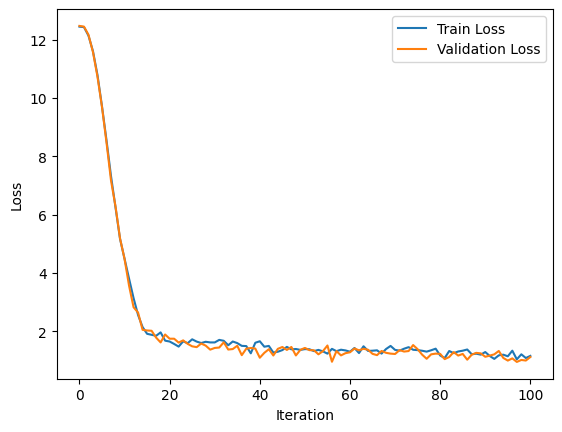

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

while True:
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        print(f"step {iter_num}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # Collect the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y, fens = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item()  # loss as float. note: this is a CPU-GPU sync point
        # if local_iter_num >= 5:  # let the training loop settle a bit
        #     mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
        #     running_mfu = mfu if running_mfu == -1.0 else 0.9 * running_mfu + 0.1 * mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt * 1000:.2f}ms")

    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > 100:
        break

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def get_test_data(): 
    dataloader = test
    batch = next(iter(dataloader))
    # fens = [[fen_to_tensor(fen) for fen in game['FEN']] for game in batch]
    fens = [[fen for game['FEN']] for game in batch]
    pgns = [[pgn for game['PGN']] for game in batch] # shape batch_size x block_size 
    # y = torch.stack([torch.cat((torch.from_numpy((game['np'][1:]).astype(np.int64)), torch.tensor([0]))) for game in batch]) # shape batch_size x block_size
    # p = torch.stack([torch.stack([fen_tensor for fen_tensor in game]) for game in fens]) # shape batch_size x block_size x 128 
    game_lengths = [game['game_length'] for game in batch]
    game_colors = [game['color'] for game in batch]
    # print(x.shape)
    # print(y.shape)
    # print(p.shape)
    # if device == 'cuda': 
    #   x = x.pin_memory().to(device, non_blocking=True)
    # else: 
    #   x = x.to(device) 

    return pgns, fens, game_lengths, game_colors


In [ ]:
# print(len(x))

In [ ]:
  # vocab = dataset.pgn_vocab_stripped
  
  # stoi = { move:i for i, move in enumerate(vocab) }
  # itos = { i:move for i, move in enumerate(vocab) }

  # def encode(pgn): 
  #     return [stoi[move] for move in pgn]
  # def decode(l): 
  #     return [itos[i] for i in l]


In [ ]:
# x = encode(["e4", "e5", "Nf3", "Nf6"])
# print(x)

In [ ]:
# x, y, fens = get_batch('test')

# # def 

torch.Size([8, 512])


In [ ]:
test_iters = 10
# max_new_tokens = 1
# temperature = 0.8
# top_k = 20

correct_list = []
trials_list = []]
accuracies = []

with torch.no_grad(): 
  with ctx: 
    for k in range(test_iters): 
      pgns, fens, game_lengths, game_colors = get_test_data() #size of 8 x _ 
      for i in range(batch_size):
        pgn = pgns[i]
        fen = fens[i]
        game_length = game_lengths[i]
        color = game_colors[i] 
        pad = 0 if color == "white" else 1 
        correct = 0.0 
        trials = 0.0 
        if game_length < 20: 
          continue 
        for j in range(10*2 + pad, game_length - 1, 2): 
          pgn_up_to_move = pgn[:j]
          fen_position = fen[:j]
          # don't need to pad 
          x = torch.tensor(encode(pgn_up_to_move))
          y = model.generate(x, fen_position)
          trials += 1 
          new_pgn = decode(y.tolist())
          if new_pgn == pgn[:j+1]
            correct += 1 
        correct_list.append(correct)
        trials_list.append(trials) 
        accuracies.append(correct / trials)

['d4', 'Nf6', 'c4', 'c5', 'd5', 'g6', 'Nc3', 'Bg7', 'e4', 'd6', 'Be2', 'O-O', 'Nf3', 'e5', 'O-O', 'Ne8', 'a3', 'b4', 'Qe7', 'Rb1', 'h6', 'g3', 'Nc7', 'Be3', 'b6', 'Nh4', 'Kh7', 'Qc2', 'Bf6', 'Ng2', 'Bd3', 'Nf6', 'f3', 'Bh3', 'bxc5', 'bxc5', 'Rb3', 'Rfb8', 'Rfb1', 'Nd7', 'Rxb8', 'Rxb8', 'Rxb8', 'Nb5', 'Na8', '', '1/2-1/2', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '